# One Piece to the Puzzle

### Some Time Series Modeling, Exploratory Analysis: 

Below code transforms historic nickel data to be used by multivariate regression algorithms to make price
forecasts for one-year ahead of time.

A target variable, y (which represents one year ahead of time) is constructed by shifting all other 
variables back by one year. 



In [4]:
import matplotlib.pyplot as plt
import numpy as np

x = np.random.randn(50)
x
y = np.random.randn(50)

z = np.random.randn(50)

plt.figure(200)
plt.plot(x)
plt.show()

plt.figure(222)
plt.plot(y)
plt.show()

plt.figure(333)
plt.plot(z)
plt.show()

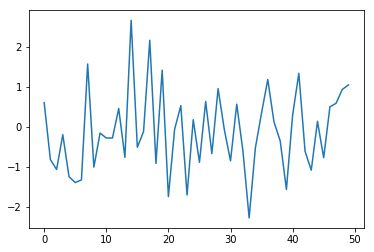

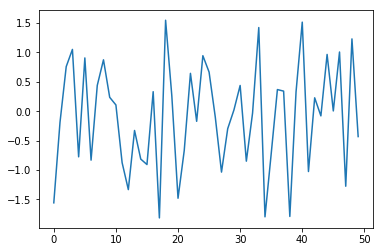

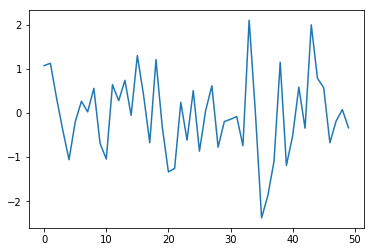

In [5]:
plt.figure(200)
plt.plot(x)
plt.show()

plt.figure(222)
plt.plot(y)
plt.show()

plt.figure(333)
plt.plot(z)
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from pylab import rcParams
rcParams['figure.figsize'] = 9, 6
import ast


In [33]:
'''

Time Series Modeling/Explorations Portion: 

Below code transforms historic nickel data to be used by multivariate regression algorithms to make price

forecasts for one-year ahead of time. Features are created by taking lagged copies of itself and a target

variable, y, which represents one year ahead of time, can be built by shifting all other X variables 

back by one year (261 business days). 

'''

'\n\nTime Series Modeling/Explorations Portion: \n\nBelow code transforms historic nickel data to be used by multivariate regression algorithms to make price\n\nforecasts for one-year ahead of time. Features are created by taking lagged copies of itself and a target\n\nvariable, y, which represents one year ahead of time, can be built by shifting all other X variables \n\nback by one year (261 business days). \n\n'

In [34]:
def LME_clean():
    '''Reads source file and cleans and reformats data as a time series in business days (B) as time units'''
    
    LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
    LME_futures = LME_futures.iloc[3:, 1:]
    LME_futures.columns = ['Date', 'Cash Price ($/MT)', 'Inventory (MT)']
    LME_futures.index = LME_futures['Date']
    LME_futures = LME_futures[LME_futures.index.year>=2018] # For now only use years after 2005

    LME_futures = LME_futures.iloc[:, 1:]

    LME = LME_futures.iloc[:, 0]
    LME = LME.astype(float)
    LME = LME.resample('B').mean()
    LME = LME.squeeze()
    return LME

def stationarity_preprocess(series, window_setting):
    '''
    Transforms Series data by taking difference of rolling average method for time series stationary. This 
    will allow us to build more effective predictive models.'''
    
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

def reverse_stationarity(series, train_tail, window_setting):
    '''
    Uses moving averages from the tail-end of training data 
    before using its own unscaled predictions to perform reverse differencing.
    '''
    unscaled = []
    for key, item in series.items():
        moving_avg = train_tail.tail(window_setting).mean()
        unscaled_result = item+moving_avg # reverse of differencing
        train_tail = train_tail.append(pd.Series([unscaled_result])) # Appends to tail-end of train_tail series before moving average is taken again
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled.index = series.index
    return unscaled

def time_series_train_test_split(df):

    X = df[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 
           ]]
    y= df['y']
    X_test = X.loc['2017-10-14':,:]
    y_test = y['2017-10-14':]
    X_train = X.loc[:'2017-10-14', :]
    y_train = y[:'2017-10-14']
    return X_train, X_test, y_train, y_test

def time_series_train_test_split_no_gap(df):

    X = df[['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 
           ]]
    y= df['lag0']
    X_test = X.loc['2017-10-14':,:]
    y_test = y['2017-10-14':]
    X_train = X.loc[:'2017-10-14', :]
    y_train = y[:'2017-10-14']
    return X_train, X_test, y_train, y_test

def minimum_mae(mae_results, model_name):
    
    '''Takes in dictionary of mae_results and parameter settings outputed from grid search
    and 1. calculates the optimal mae and associated parameter settings and 2. prints all mae results.'''
    
    key_min = min(mae_results.keys(), key=(lambda k: mae_results[k]))
    min_test_mae = mae_results[key_min]
    min_parameters = key_min

    print()
    print(str(model_name) + ' MAE Results by Parameter Setting:')
    for key, value in mae_results.items():
        print(key, value)
        
    print()
    print(str(model_name) + ' Minimum Test MAE: ', min_test_mae)
    print(str(model_name) + ' Best Parameters: ', min_parameters)

    return min_test_mae, min_parameters

def fit_predict(model, X_train, X_test, y_train, y_test, train_tail):
    '''
    1) Fits model on training data
    2) Makes predictions on test data
    3) Calls reverse_stationarity function 
    '''
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    y_pred_unscaled = reverse_stationarity(y_pred, train_tail, window_setting)
    y_unscaled = reverse_stationarity(y_test, train_tail, window_setting)
    return y_pred_unscaled, y_unscaled


def regression_plot(y_hat, y, model_name):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format - %b gives us Jan, Feb...
    fmt = mdates.DateFormatter('%m-%y')

    
    plt.plot(y_hat)
    plt.plot(y)
    

    X = plt.gca().xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
    plt.legend(['y_hat', 'y'])
    plt.grid(linestyle="dashed")
    plt.title(model_name + ' Regression Prediction Results', fontsize=15)

    plt.show()
    
def preprocess_time_series(window_setting, lag_length):
    '''Prepares time series data for supervised learning experiments by creating additional lagged columns of the original
    column and assigning a target y variable by pushing all predictor X variables back by one year'''
    LME = LME_clean()    
    LME_shifted = LME.shift(-261).dropna()

    LME_stationary = stationarity_preprocess(LME, window_setting)
    df = pd.DataFrame(list(zip(list(LME_stationary.index), list(LME_stationary))), columns = ['ds', 'lag0'])
    
    for i in range(1, 11):
        lag_string = 'lag'+str(i)
        df[lag_string] = df.lag0.shift(periods=i*lag_length)

    df.index = df['ds']
    df = df.iloc[:, 1:]

    
    df['y'] = df['lag0'].shift(-261)
    df = df.dropna()

    return df, LME_shifted

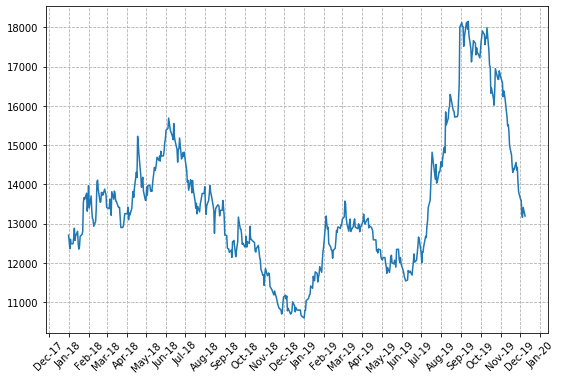

ValueError: No figure <module 'matplotlib.pyplot' from 'C:\\Users\\ckato\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [45]:
import matplotlib.dates as mdates

import matplotlib.backends.backend_pdf

LME = LME_clean()

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b-%y')

plt.plot(LME)


X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks( rotation=45 )

plt.grid(linestyle="dashed")

pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
plt.show()
pdf.savefig(plt)

##################

plt.plot(LME_shifted)


X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks( rotation=45 )

plt.grid(linestyle="dashed")
plt.show()
pdf.savefig( plt )


#for fig in xrange(1, figure().number): ## will open an empty extra figure :(
pdf.close()


In [42]:
import fpdf

data=[1,2,3,4,5,6]

pdf = fpdf.FPDF(format='letter')
pdf.add_page()
pdf.set_font("Arial", size=12)

for i in data:
    pdf.write(5,str(i))
    pdf.ln()
pdf.output("testings.pdf")


ModuleNotFoundError: No module named 'fpdf'

In [35]:
'''
The following functions 

    1) Fit models on training data/make predictions on test data
    2) Execute parameter tuning (depending on method used)
    2) Assess mean absolute errors (mae's) of multiple models and identifies/outputs highest performing model/set of parameters
    
'''


def run_linear_reg(X_train, X_test, y_train, y_test, train_tail):
    '''No parameter tuning for linear reg model'''

    # Model Fitting & Predictions
    regressor = LinearRegression()
    y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
    mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
    model_name = str(regressor).split('(')[0]
    print('Test Linear Regression MAE: ', mae)

    regression_plot(y_pred_unscaled, y_unscaled, model_name)

    min_test_mae = mae
    min_parameters = 'None'
    return min_test_mae, min_parameters, model_name



def run_polynomial(X_train, X_test, y_train, y_test, train_tail):
    '''Polynomial regression needs to be fitted manually, since it piggybacks off of linear regression model'''
    
    params1= range(2,5) # Evaluates different degrees of polynomial curve

    mae_results = {}

    for deg in params1:
        # Model Fitting & Predictions
        polynomial_features= PolynomialFeatures(degree=deg)

        X_poly = polynomial_features.fit_transform(X_train)

        regressor = LinearRegression()
        regressor.fit(X_poly, y_train)

        X_poly_test = polynomial_features.fit_transform(X_test)
        y_poly_pred = regressor.predict(X_poly_test)
        y_poly_pred = pd.Series(y_poly_pred)
        y_poly_pred.index = y_test.index
        
        y_pred_unscaled, y_unscaled = reverse_stationarity(y_poly_pred, train_tail, window_setting), reverse_stationarity(y_test, train_tail, window_setting)
        
        mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
        mae_results[str(deg)] = mae

    # To find the best/optimal parameters
    model_name = "Polynomial"
    min_test_mae, min_parameters = minimum_mae(mae_results, model_name) 
    min_parameters = ast.literal_eval(min_parameters)
    
    polynomial_features= PolynomialFeatures(degree=min_parameters)

    X_poly = polynomial_features.fit_transform(X_train)

    regressor = LinearRegression()
    regressor.fit(X_poly, y_train)

    X_poly_test = polynomial_features.fit_transform(X_test)
    y_poly_pred = regressor.predict(X_poly_test)
    y_poly_pred = pd.Series(y_poly_pred)
    y_poly_pred.index = y_test.index

    y_pred_unscaled, y_unscaled = reverse_stationarity(y_poly_pred, train_tail, window_setting), reverse_stationarity(y_test, train_tail, window_setting)
            
    regression_plot(y_pred_unscaled, y_unscaled, model_name)

    
    return min_test_mae, min_parameters, model_name


def run_lasso_grid(X_train, X_test, y_train, y_test, train_tail):
    
    params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                                })
    mae_results = {}

    for params in params1:
        # Model Fitting & Predictions
        regressor = linear_model.Lasso(**params, random_state=1)  
        y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
        mae_results[str(params)] = mae

    # To find the best/optimal parameters
    model_name = str(regressor).split('(')[0]
    min_test_mae, min_parameters = minimum_mae(mae_results, model_name) 
    min_parameters = ast.literal_eval(min_parameters) # Converts optimal parameters string to dict
    regressor = linear_model.Lasso(**min_parameters, random_state=1)

    y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        
    regression_plot(y_pred_unscaled, y_unscaled, model_name)

    
    return min_test_mae, min_parameters, model_name


def run_adaboost_grid(X_train, X_test, y_train, y_test, train_tail):
    '''Executes parameter tuning using grid search. 
    One final set of parameters is chosen and outputted with resulting MAE'''
    
    params1= ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250],
                            'learning_rate': [ .1, .01, .001, .0001]})

    mae_results = {}

    for params in params1:
        # Model Fitting & Predictions
        regressor = AdaBoostRegressor(**params, random_state=1)
        y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)

        mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
        mae_results[str(params)] = mae

    # To find the best/optimal parameters
    model_name = str(regressor).split('(')[0]
    min_test_mae, min_parameters = minimum_mae(mae_results, model_name) 
    min_parameters = ast.literal_eval(min_parameters) # Converts optimal parameters string to dict
    regressor = AdaBoostRegressor(**min_parameters, random_state=1)
    
    y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
    regression_plot(y_pred_unscaled, y_unscaled, model_name)
    
    return min_test_mae, min_parameters, model_name

def run_rf_grid(X_train, X_test, y_train, y_test, train_tail):
    '''Random Forest Regression'''
    
    params1=  ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250, 300],
                            'min_samples_leaf': [ .15,  .25, .35, .45]})
    mae_results = {}

    for params in params1:
        # Model Fitting & Predictions
        regressor = RandomForestRegressor(**params, random_state=1) 
        y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
        mae_results[str(params)] = mae

    # To find the best/optimal parameters
    model_name = str(regressor).split('(')[0]
    min_test_mae, min_parameters = minimum_mae(mae_results, model_name) 
    min_parameters = ast.literal_eval(min_parameters) # Converts optimal parameters string to dict
    regressor = RandomForestRegressor(**params, random_state=1)

    y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
    regression_plot(y_pred_unscaled, y_unscaled, model_name)
    
    return min_test_mae, min_parameters, model_name


def run_knn(X_train, X_test, y_train, y_test, train_tail):
    
    params1= range(1,67,3) # Evaluates different values of K number of observations in a neighborhood
    
    mae_results = {}

    for K in params1:
        # Model Fitting & Predictions
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
        y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
        mae_results[str(K)] = mae

    # To find the best/optimal parameters
    model_name = str(regressor).split('(')[0]
    min_test_mae, min_parameters = minimum_mae(mae_results, model_name) 
    min_parameters = ast.literal_eval(min_parameters) # Converts optimal parameters string to dict
    regressor = regressor = neighbors.KNeighborsRegressor(n_neighbors=min_parameters)

    y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
   
    regression_plot(y_pred_unscaled, y_unscaled, model_name)
    return min_test_mae, min_parameters, model_name

In [36]:
if __name__ == "__main__":
    window_setting= 5*4 # Rolling Average window setting for stationarity_preprocess function

    lag_length = 10 # lag length 2 weeks (5 business days)
    df, LME_shifted = preprocess_time_series(window_setting, lag_length)
    
    model_functions = [run_linear_reg,
             run_polynomial,
             run_lasso_grid,
             run_adaboost_grid,
             run_rf_grid,
             run_knn]
    
    # Evaluations for one year ahead of time predictions compared to just one day ahead predictions (no gap)
    for j, y_lag_type in enumerate([time_series_train_test_split(df), time_series_train_test_split_no_gap(df)]):
        if j == 0:
            print("One Year Ahead of Time Predictions")
            print()
        else:
            print("One Day Ahead Predictions")
            print()
        X_train, X_test, y_train, y_test = y_lag_type
        train_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        mae = []
        parameter_setting = []
        model_name_list = []

        for i in range(5):
            min_test_mae, min_parameters, model_name = model_functions[i](X_train, X_test, y_train, y_test, train_tail)
            mae.append(min_test_mae)
            parameter_setting.append(min_parameters)
            model_name_list.append(model_name)
       
        if j == 0:
            results = pd.DataFrame({'model_name': model_name_list, 'mae': mae, 'parameters': parameter_setting})
            results.to_csv('results/automodeling_mae.csv', index = False)

One Year Ahead of Time Predictions



ValueError: Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.

### New



In [37]:
X_train

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
ds,,,,,,,,,,,


Test MAE:  1662.9468654921607


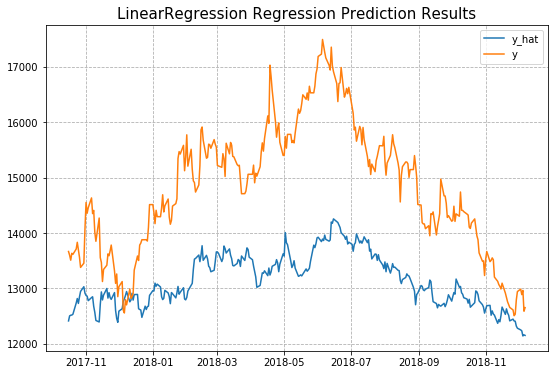


MAE Results by Parameter Setting:
2 1175.9846292816144
3 761.0707242076479
4 945.2139169212273

Minimum Test MAE:  761.0707242076479
Best Parameters:  3


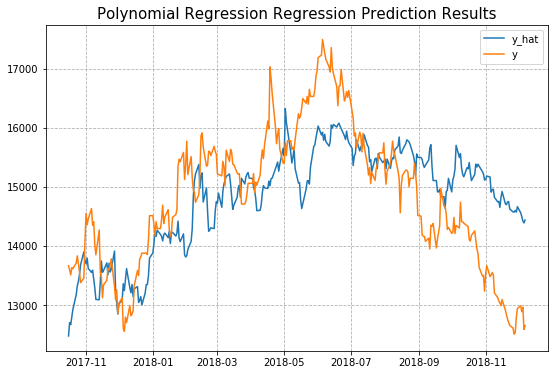


MAE Results by Parameter Setting:
{'alpha': 1e-05} 1662.9468655056294
{'alpha': 0.0001} 1662.9468656279964
{'alpha': 0.001} 1662.9468668543952
{'alpha': 0.01} 1662.9468790681908
{'alpha': 0.1} 1662.9469997144618
{'alpha': 1} 1662.94818631197

Minimum Test MAE:  1662.9468655056294
Best Parameters:  {'alpha': 1e-05}


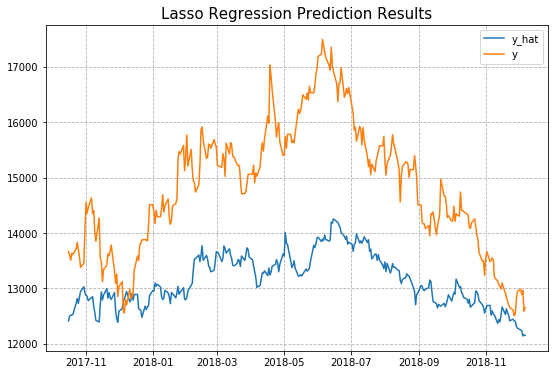


MAE Results by Parameter Setting:
{'learning_rate': 0.1, 'n_estimators': 50} 1352.2395280222518
{'learning_rate': 0.1, 'n_estimators': 100} 1267.2395109681402
{'learning_rate': 0.1, 'n_estimators': 150} 1342.5092205739545
{'learning_rate': 0.1, 'n_estimators': 200} 1598.1247219190723
{'learning_rate': 0.1, 'n_estimators': 250} 1817.966706778851
{'learning_rate': 0.01, 'n_estimators': 50} 1291.886505701608
{'learning_rate': 0.01, 'n_estimators': 100} 1198.371683837774
{'learning_rate': 0.01, 'n_estimators': 150} 1323.3915943932866
{'learning_rate': 0.01, 'n_estimators': 200} 1427.9369519750837
{'learning_rate': 0.01, 'n_estimators': 250} 1405.4394411410317
{'learning_rate': 0.001, 'n_estimators': 50} 1453.584367668518
{'learning_rate': 0.001, 'n_estimators': 100} 1381.4804967384441
{'learning_rate': 0.001, 'n_estimators': 150} 1347.4375878686544
{'learning_rate': 0.001, 'n_estimators': 200} 1350.5517972412863
{'learning_rate': 0.001, 'n_estimators': 250} 1365.039941004427
{'learning_ra

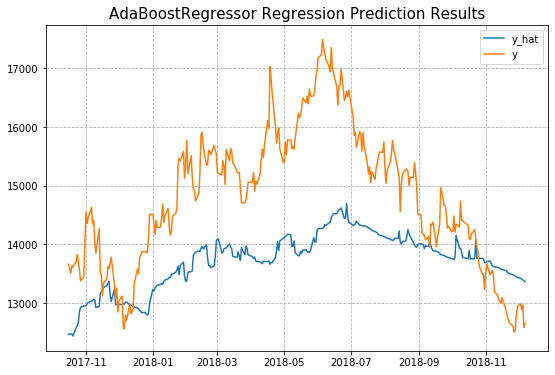


MAE Results by Parameter Setting:
{'min_samples_leaf': 0.15, 'n_estimators': 50} 1172.4041814890088
{'min_samples_leaf': 0.15, 'n_estimators': 100} 1115.570915908886
{'min_samples_leaf': 0.15, 'n_estimators': 150} 1078.8567478356538
{'min_samples_leaf': 0.15, 'n_estimators': 200} 1074.2171328611137
{'min_samples_leaf': 0.15, 'n_estimators': 250} 1049.390779431973
{'min_samples_leaf': 0.15, 'n_estimators': 300} 1041.0421796647756
{'min_samples_leaf': 0.25, 'n_estimators': 50} 1174.749577368381
{'min_samples_leaf': 0.25, 'n_estimators': 100} 1150.8416185886508
{'min_samples_leaf': 0.25, 'n_estimators': 150} 1126.7915098626722
{'min_samples_leaf': 0.25, 'n_estimators': 200} 1124.106625490553
{'min_samples_leaf': 0.25, 'n_estimators': 250} 1116.3616023220777
{'min_samples_leaf': 0.25, 'n_estimators': 300} 1113.8710177062442
{'min_samples_leaf': 0.35, 'n_estimators': 50} 2508.2638846153154
{'min_samples_leaf': 0.35, 'n_estimators': 100} 2514.5584700750333
{'min_samples_leaf': 0.35, 'n_esti

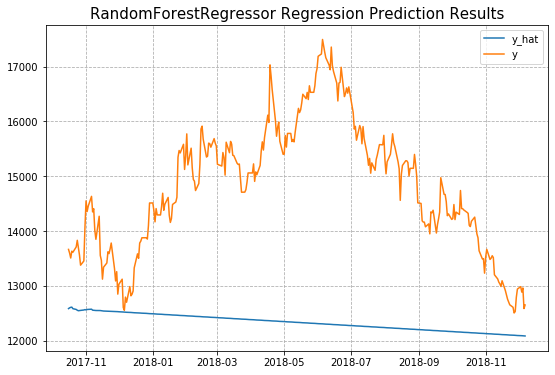


MAE Results by Parameter Setting:
1 1406.7157121838295
4 1333.504973199537
7 1327.0977765002895
10 1329.2890163986567
13 1365.3011668322756
16 1349.6967704974159
19 1319.0681497239798
22 1329.8888303995543
25 1322.6103772491128
28 1310.4649889629447
31 1316.9132986772045
34 1303.8538363621842
37 1290.7240703467362
40 1301.5533081686888
43 1289.6478203903953
46 1279.0859688979383
49 1280.1720297039415
52 1266.6909101915292
55 1257.7255632596948
58 1251.2802598770036
61 1264.2928304309787
64 1257.1503716703585

Minimum Test MAE:  1251.2802598770036
Best Parameters:  58


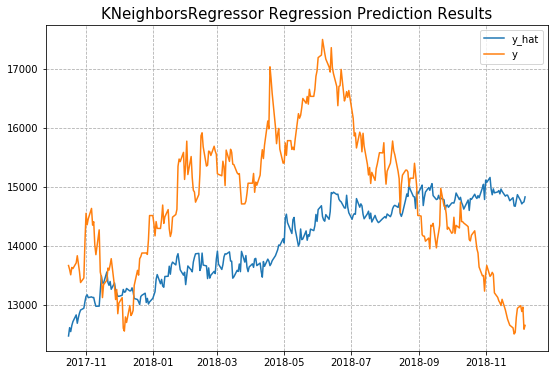

In [108]:

#min_test_mae, min_parameters, model_name = run_rf_grid(X_train, X_test, y_train, y_test, train_tail)

'''

functions = [run_linear_reg,
             run_polynomial,
             run_lasso_grid,
             run_adaboost_grid,
             run_rf_grid,
             run_knn]
'''

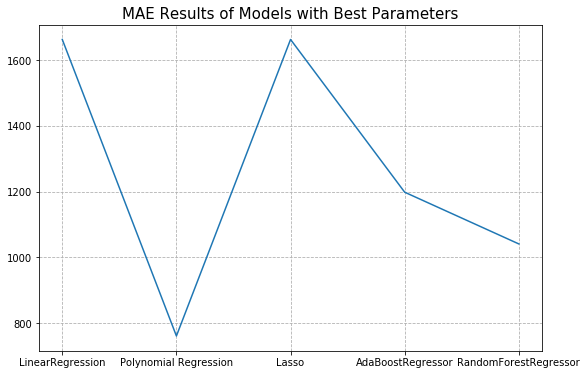

In [91]:

plt.plot(model_name_list, mae)
plt.grid(linestyle="dashed")
plt.title('MAE Results of Models with Best Parameters', fontsize=15)

plt.show()

In [ ]:
plt.plot(df_results['results'])
plt.title('MAE Results (full) for 16 years training period testing for one year test period\n ' + 'MAE: '+ str(df_results['results'].mean()), fontsize=15)
plt.axhline(df_results['results'].mean(), color='r', linestyle='dotted')
plt.grid(linestyle='dashed')
plt.show()

In [ ]:
'''
y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index
'''

# Other Kinds of Regression

Grid Search for RIDGE Regression

# MAIN GOOD ONES
Knn K=6 
2 week lags at 3 week rolling average windows 

Knn K=7
4 week lags at 4 week rolling average windows 

Polynomial 
4 month lags 8 week rolling average windows


ds
2017-10-16    12516.5
2017-10-17    12298.5
2017-10-18    12276.0
2017-10-19    12372.0
2017-10-20    12447.5
dtype: float64
ds
2000-11-06    4521.0
2000-11-07    4532.0
2000-11-08    4614.0
2000-11-09    4891.0
2000-11-10    5499.5
dtype: float64


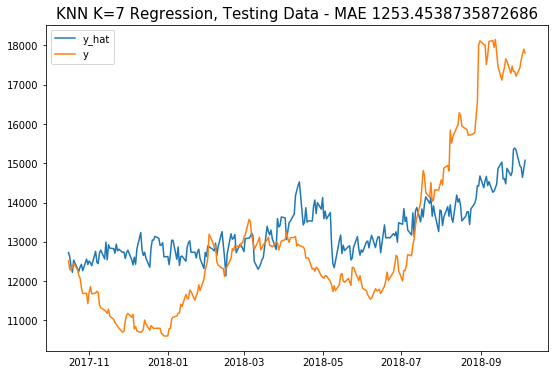

Mean Absolute Error: 1253.4538735872686
Mean Squared Error: 2347471.5514717815
Root Mean Squared Error: 1532.1460607500126


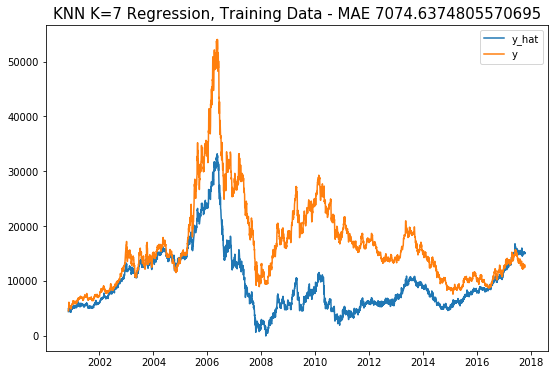

Mean Absolute Error: 7074.6374805570695
Mean Squared Error: 84440250.35487752
Root Mean Squared Error: 9189.137628465334


In [183]:
K = 7
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
regressor.fit(X_train, y_train)

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
y_pred_unscaled = reverse_stationarity(y_pred, original_tail, window_setting)
y_pred_unscaled.index = y_test.index


y_unscaled = reverse_stationarity(y_test, original_tail, window_setting)
y_unscaled.index = y_test.index
print(y_unscaled.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K) +' Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


ds
2017-10-16    12516.5
2017-10-17    12298.5
2017-10-18    12276.0
2017-10-19    12372.0
2017-10-20    12447.5
dtype: float64
ds
2000-11-06    4521.0
2000-11-07    4532.0
2000-11-08    4614.0
2000-11-09    4891.0
2000-11-10    5499.5
dtype: float64


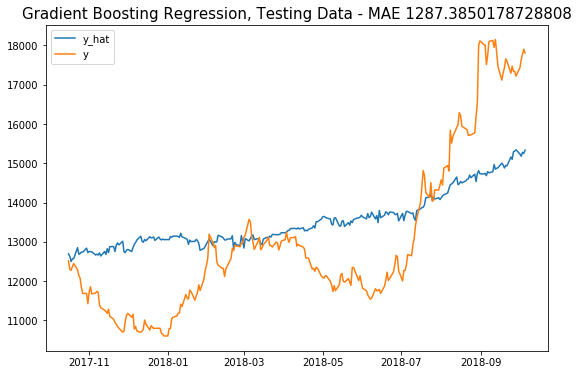

Mean Absolute Error: 1287.3850178728808
Mean Squared Error: 2380259.539884321
Root Mean Squared Error: 1542.8089771207326


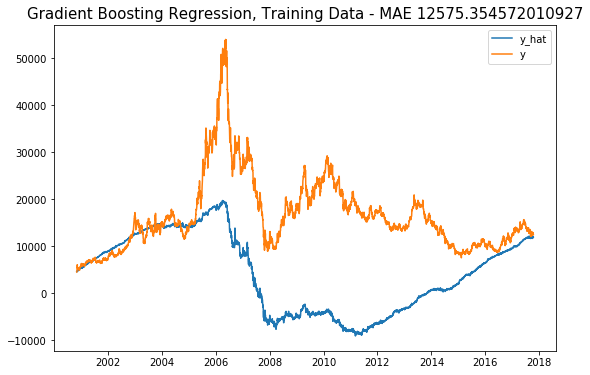

Mean Absolute Error: 12575.354572010927
Mean Squared Error: 264481461.72992408
Root Mean Squared Error: 16262.886020935031


In [33]:
regressor=mid_model

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Gradient Boosting Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/gradient_boost_mid_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Gradient Boosting Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/gradient_boost_mid_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))

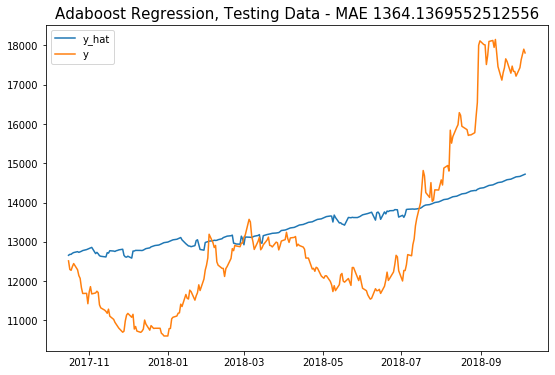

Mean Absolute Error: 1364.1369552512556
Mean Squared Error: 2668909.322509097
Root Mean Squared Error: 1633.6796878547204


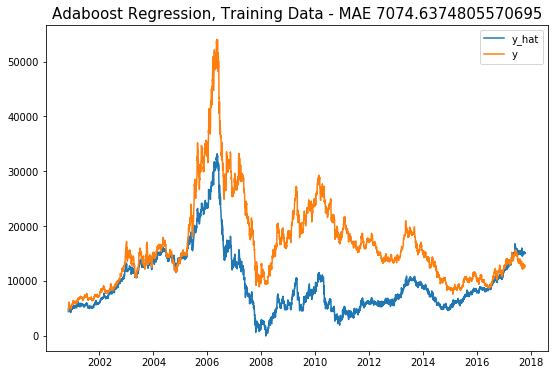

Mean Absolute Error: 7074.6374805570695
Mean Squared Error: 84440250.35487752
Root Mean Squared Error: 9189.137628465334


In [184]:
regressor = AdaBoostRegressor(learning_rate=.0001, n_estimators=50, random_state=1)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


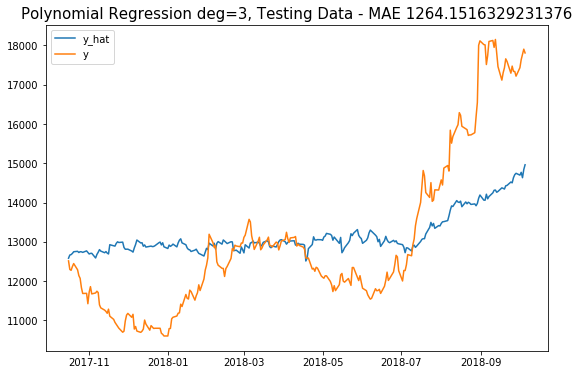

Mean Absolute Error: 1264.1516329231376
Mean Squared Error: 2543648.9721006383
Root Mean Squared Error: 1594.882118559437


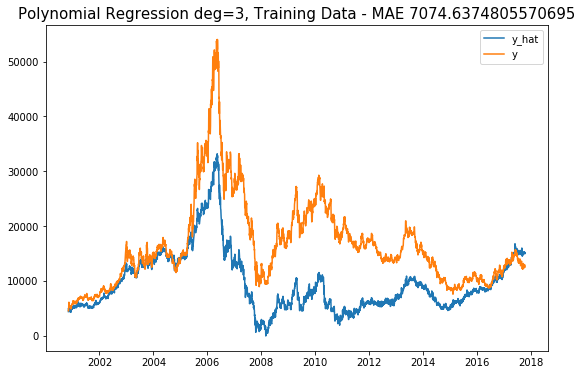

Mean Absolute Error: 7074.6374805570695
Mean Squared Error: 84440250.35487752
Root Mean Squared Error: 9189.137628465334


In [185]:
polynomial_features= PolynomialFeatures(degree=3)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

y_pred = y_poly_pred


X_poly_train = polynomial_features.fit_transform(X_train)
y_poly_pred = regressor.predict(X_poly_train)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_train.index

y_pred_train_unscaled = y_poly_pred


##############

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))





In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725
